In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import keras
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Activation
from keras.layers import Dropout, Input, BatchNormalization
from keras.losses import mae, mse, binary_crossentropy
from keras.optimizers import Adam, Adadelta, Adagrad, SGD
from keras.models import Model

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k
 
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
#config.gpu_options.allow_growth = True
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################

## seed
np.random.seed(1)
tf.set_random_seed(2)

In [4]:
def Conv3D_model(input_shape):
    input_layer = Input(input_shape)
    prev_layer = input_layer
    for i in range(5):
        conv_layer1 = Conv3D(filters=(i+1)*8, kernel_size=(3, 3, 3))(prev_layer)
        conv_layer1 = Activation('relu')(conv_layer1)
        conv_layer2 = Conv3D(filters=(i+1)*8, kernel_size=(3, 3, 3))(conv_layer1)
        conv_layer2 = BatchNormalization()(conv_layer2)
        conv_layer2 = Activation('relu')(conv_layer2)
        pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)
        prev_layer = pooling_layer2

#     flatten_layer = Dropout(0.5)(prev_layer)
#     flatten_layer = Flatten()(flatten_layer)
    
    flatten_layer = Flatten()(prev_layer)
    
    age_layer = Dense(units=1, activation='linear' , name='age')(flatten_layer)
    sex_layer = Dense(units=1, activation='sigmoid', name='sex')(flatten_layer)
    
    return Model(inputs=input_layer, outputs=[age_layer, sex_layer])

In [5]:
class DataGen:
    
    def __init__(self, csv,  directory):
        df = pd.read_csv(csv)
        self.dir = directory
        self.filename = np.array(df['file'])
        self.age      = np.array(df['age'])
        self.gender   = np.array(df['gender'])=='f'
        
        one_brain = np.array(nib.load( os.path.join(self.dir, self.filename[0]) ).get_data())
        self.shape = one_brain.shape
        self.dtype = one_brain.dtype
        self.total_samples = len(self.filename)
        
        self.next_index = 0
        self.init()
        
        
    def init(self):
        rand_indicies = np.random.permutation(np.arange(len(self.filename)))
        self.filename = self.filename[rand_indicies]
        self.age = self.age[rand_indicies]
        self.gender = self.gender[rand_indicies]
        self.next_index = 0
        
    def samples_left(self):
        return self.total_samples - self.next_index
        
    def getBatch(self, n_samples):
        n_samples_left = self.samples_left()
        assert n_samples_left>0, "No samples left, call dataGen.init()"
        
        n_samples = n_samples if n_samples_left>n_samples else n_samples_left
        data = np.empty((n_samples,)+self.shape+(1,), self.dtype)
        age_label = np.empty(n_samples, self.dtype)
        sex_label = np.empty(n_samples, self.dtype)
        # should spawn a thread to load data
        for i in range(n_samples):
            data[i,:,:,:,0] = np.array(nib.load(os.path.join(self.dir, self.filename[self.next_index])).get_data())
            age_label[i] = self.age[self.next_index]
            sex_label[i] = self.gender[self.next_index]
            self.next_index = self.next_index+1
        
        return data, [age_label, sex_label]
    
    # generator for keras fit_generator function
    def generator(self, batch_size, num_batches_to_load):
        # using a batch_size such that i*batch_size = dataset_size
        assert self.total_samples%batch_size == 0, "Batch_size should be a divisor of DataGen.total_sample"
        num_batches = self.total_samples//batch_size
        assert num_batches%num_batches_to_load==0, "num_batches_to_load should be a divisor of num_batches"
        num_loads = num_batches//num_batches_to_load
        while True:
            self.init()
            for load in range(num_loads):
                X, y = self.getBatch(num_batches_to_load*batch_size)
                age,sex = y
                for index in range(num_batches_to_load):
                    yield (X[index*batch_size:(index+1)*batch_size], [age[index*batch_size:(index+1)*batch_size], sex[index*batch_size:(index+1)*batch_size]])


In [6]:
def kerasPlot(history):
    plt.subplot(3, 1, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(3, 2, 3)
    plt.title('Age')
    plt.plot(history.history['age_loss'])
    plt.plot(history.history['val_age_loss'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(3, 2, 4)
    plt.title('Sex')
    plt.plot(history.history['sex_loss'])
    plt.plot(history.history['val_sex_loss'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(3, 2, 5)
    plt.plot(history.history['age_mean_absolute_error'])
    plt.plot(history.history['val_age_mean_absolute_error'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    
    plt.subplot(3, 2, 6)
    plt.plot(history.history['sex_acc'])
    plt.plot(history.history['val_sex_acc'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

In [7]:
dg = DataGen('IXI_train.csv', './IXI_brain')
dg_val = DataGen('IXI_val.csv', './IXI_brain')
print("Training Samples:", dg.total_samples, ",  Validation Samples:", dg_val.total_samples,)

Training Samples: 450 ,  Validation Samples: 50


In [8]:
model = Conv3D_model(dg.shape+(1,))
batch_size = 5
load_size = 30 # how many batches should be in ram
epochs = 100
metrics={'age':'mae', 'sex':'accuracy'}
model.compile(loss={'age':mae, 'sex':binary_crossentropy}, optimizer='Adam', metrics=metrics)
# Adagrad prone to overfitting for some reason

In [9]:
dg_val.init()
val_data = dg_val.getBatch(dg_val.total_samples)
history = model.fit_generator(dg.generator(batch_size, load_size),
                                      steps_per_epoch =  np.ceil(dg.total_samples/batch_size),
                                      epochs = epochs,
                                      validation_data=val_data,
                                      verbose=1)

Epoch 1/100
90/90 [==============================] - 161s 2s/step - loss: 24.2516 - age_loss: 23.5625 - sex_loss: 0.6891 - age_mean_absolute_error: 23.5625 - sex_acc: 0.6311 - val_loss: 29.9808 - val_age_loss: 29.2180 - val_sex_loss: 0.7628 - val_age_mean_absolute_error: 29.2180 - val_sex_acc: 0.4800
Epoch 2/100
90/90 [==============================] - 128s 1s/step - loss: 14.8605 - age_loss: 14.1772 - sex_loss: 0.6832 - age_mean_absolute_error: 14.1772 - sex_acc: 0.6067 - val_loss: 15.1394 - val_age_loss: 12.9233 - val_sex_loss: 2.2161 - val_age_mean_absolute_error: 12.9233 - val_sex_acc: 0.4800
Epoch 3/100
90/90 [==============================] - 128s 1s/step - loss: 11.6393 - age_loss: 11.0318 - sex_loss: 0.6074 - age_mean_absolute_error: 11.0318 - sex_acc: 0.6800 - val_loss: 28.4349 - val_age_loss: 27.6137 - val_sex_loss: 0.8213 - val_age_mean_absolute_error: 27.6137 - val_sex_acc: 0.5200
Epoch 4/100
90/90 [==============================] - 129s 1s/step - loss: 10.3073 - age_loss: 

90/90 [==============================] - 127s 1s/step - loss: 3.7193 - age_loss: 3.5407 - sex_loss: 0.1787 - age_mean_absolute_error: 3.5407 - sex_acc: 0.9533 - val_loss: 11.5171 - val_age_loss: 10.9713 - val_sex_loss: 0.5459 - val_age_mean_absolute_error: 10.9713 - val_sex_acc: 0.6400
Epoch 29/100
90/90 [==============================] - 127s 1s/step - loss: 3.1469 - age_loss: 2.9857 - sex_loss: 0.1612 - age_mean_absolute_error: 2.9857 - sex_acc: 0.9600 - val_loss: 12.6045 - val_age_loss: 12.1406 - val_sex_loss: 0.4639 - val_age_mean_absolute_error: 12.1406 - val_sex_acc: 0.7800
Epoch 30/100
90/90 [==============================] - 128s 1s/step - loss: 3.7007 - age_loss: 3.5327 - sex_loss: 0.1680 - age_mean_absolute_error: 3.5327 - sex_acc: 0.9489 - val_loss: 11.2054 - val_age_loss: 10.6471 - val_sex_loss: 0.5583 - val_age_mean_absolute_error: 10.6471 - val_sex_acc: 0.7000
Epoch 31/100
90/90 [==============================] - 127s 1s/step - loss: 3.4029 - age_loss: 3.2372 - sex_loss: 

90/90 [==============================] - 127s 1s/step - loss: 2.2758 - age_loss: 2.2309 - sex_loss: 0.0449 - age_mean_absolute_error: 2.2309 - sex_acc: 0.9956 - val_loss: 9.2461 - val_age_loss: 8.6492 - val_sex_loss: 0.5969 - val_age_mean_absolute_error: 8.6492 - val_sex_acc: 0.7000
Epoch 56/100
90/90 [==============================] - 139s 2s/step - loss: 2.1831 - age_loss: 2.1517 - sex_loss: 0.0314 - age_mean_absolute_error: 2.1517 - sex_acc: 1.0000 - val_loss: 7.3183 - val_age_loss: 6.7897 - val_sex_loss: 0.5286 - val_age_mean_absolute_error: 6.7897 - val_sex_acc: 0.7200
Epoch 57/100
90/90 [==============================] - 142s 2s/step - loss: 1.9998 - age_loss: 1.9643 - sex_loss: 0.0356 - age_mean_absolute_error: 1.9643 - sex_acc: 1.0000 - val_loss: 7.8223 - val_age_loss: 7.0926 - val_sex_loss: 0.7296 - val_age_mean_absolute_error: 7.0926 - val_sex_acc: 0.6400
Epoch 58/100
90/90 [==============================] - 140s 2s/step - loss: 2.0848 - age_loss: 2.0480 - sex_loss: 0.0368 - 

Epoch 83/100
90/90 [==============================] - 144s 2s/step - loss: 1.9432 - age_loss: 1.9232 - sex_loss: 0.0200 - age_mean_absolute_error: 1.9232 - sex_acc: 1.0000 - val_loss: 7.9259 - val_age_loss: 7.1143 - val_sex_loss: 0.8116 - val_age_mean_absolute_error: 7.1143 - val_sex_acc: 0.7200
Epoch 84/100
90/90 [==============================] - 140s 2s/step - loss: 1.6157 - age_loss: 1.6007 - sex_loss: 0.0150 - age_mean_absolute_error: 1.6007 - sex_acc: 1.0000 - val_loss: 10.5986 - val_age_loss: 9.9055 - val_sex_loss: 0.6930 - val_age_mean_absolute_error: 9.9055 - val_sex_acc: 0.6600
Epoch 85/100
90/90 [==============================] - 140s 2s/step - loss: 1.6724 - age_loss: 1.6575 - sex_loss: 0.0149 - age_mean_absolute_error: 1.6575 - sex_acc: 0.9978 - val_loss: 9.1149 - val_age_loss: 8.3818 - val_sex_loss: 0.7331 - val_age_mean_absolute_error: 8.3818 - val_sex_acc: 0.7600
Epoch 86/100
90/90 [==============================] - 143s 2s/step - loss: 1.9406 - age_loss: 1.9219 - sex_l

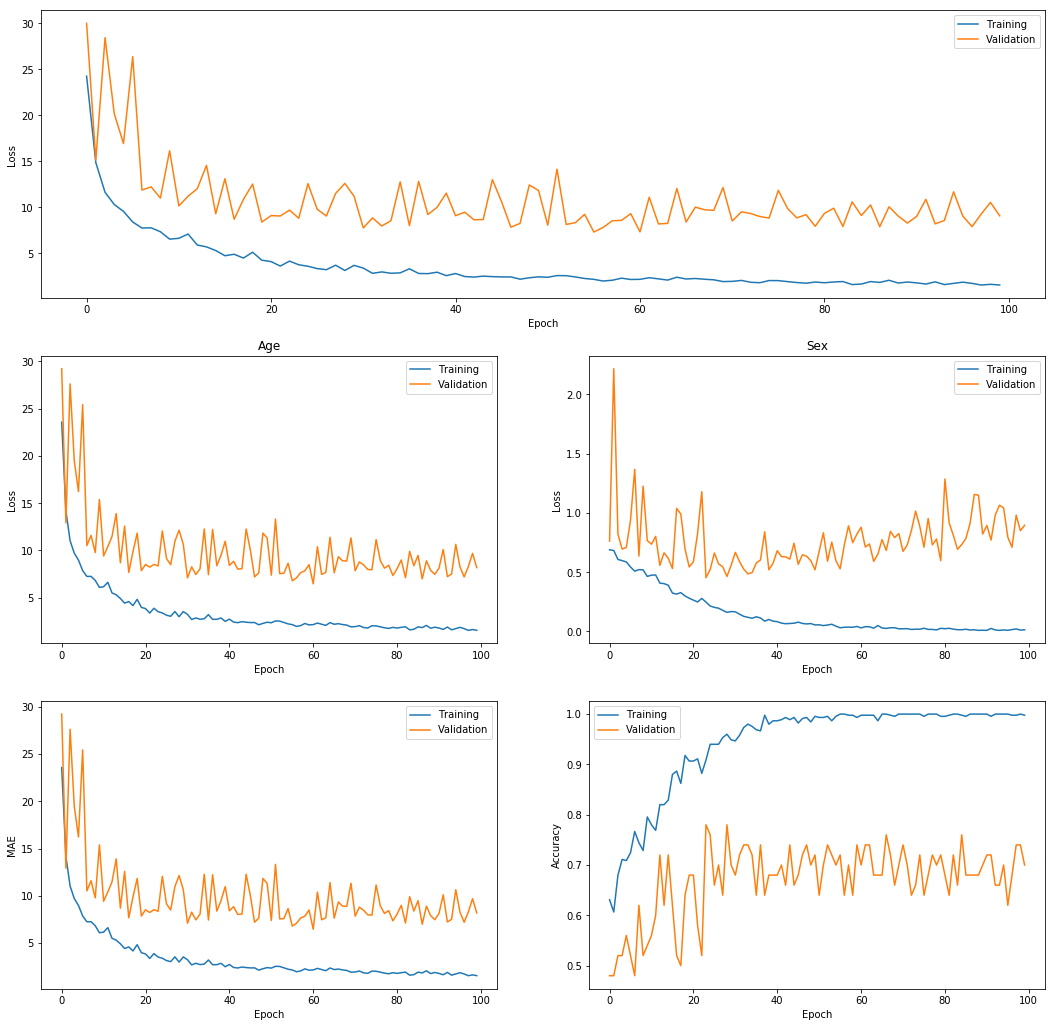

In [10]:
plt.rcParams['figure.figsize'] = [18, 18]
kerasPlot(history)